In [1]:
#Includes for the libs that I will use in this project 
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
%matplotlib inline 

In [2]:
#Camera calibration stage , In this stage the input is a cheesboard images taken by the car camera and the output
# is the camera matrix and the distortion coefficients 

# the x corners 
x_corners = 9 

#Y corners
y_corners = 6

#read calibration images 
cal_images =glob.glob('./camera_cal/*.jpg')

#define the list for the object points and the image points 
objpoints = []
imgpoints = []

#create object points , Object points is the cordinates of the cheesboard corners in the 3-D x,y,z so for ex. the 1st
#corner from the left side its cordinates is (0,0,0) and the next one is (1,0,0)

#1 create an 2D array with these dimensions (9*6), 3 and init it with zeros 
objp = np.zeros((x_corners * y_corners,3),np.float32)

#create MeshGrid with to get the object points 
objp[:,:2] = np.mgrid[0:x_corners,0:y_corners].T.reshape(-1,2)

#loop on the cal. images and detect their corners using open cv 

for fname in cal_images:
    
    #read the images 
    img = mpimg.imread(fname)
    
    #convert images to gray scale 
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (x_corners,y_corners), None)
    
    if(ret == True):
        
        #append the detected corners in the images points list 
        imgpoints.append(corners)
        
        #append the calculated object points for our chess board 
        objpoints.append(objp)
        

#getthe camera matrix and its distortion coefficients using the collected image points and calculated object points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        

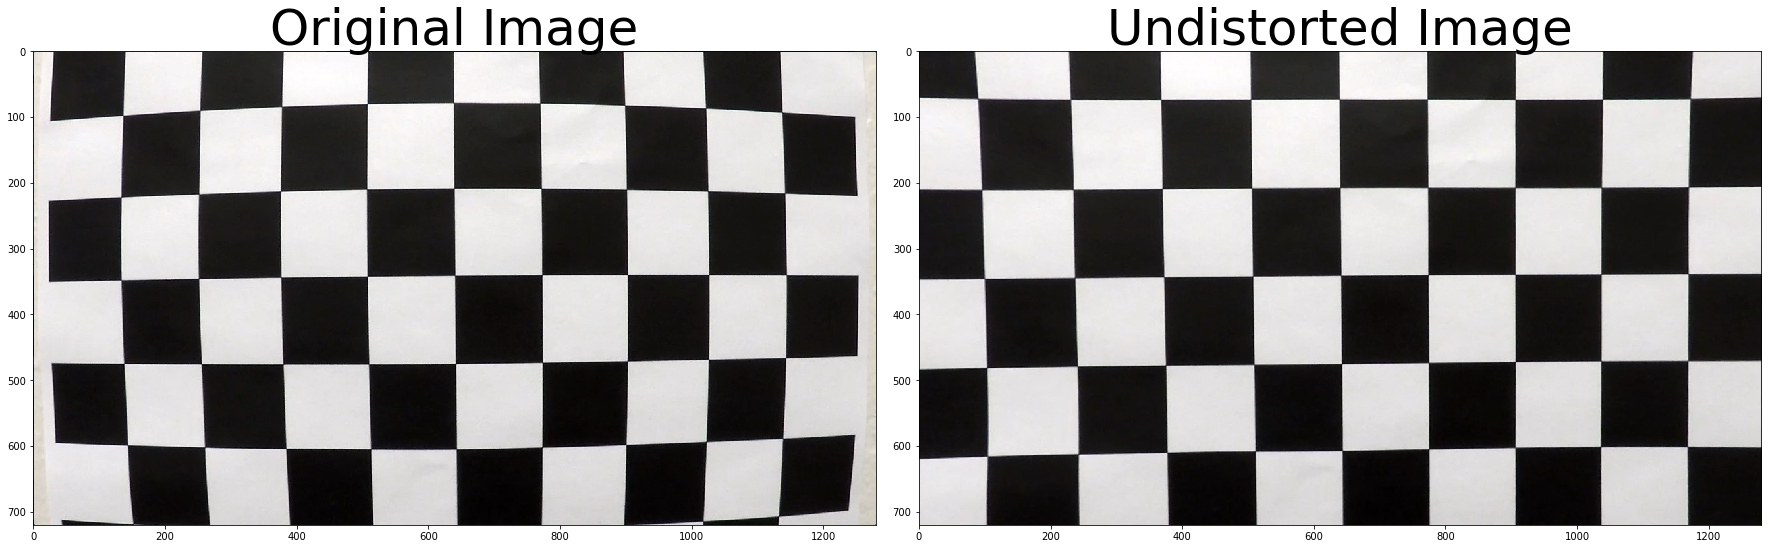

In [3]:
#Test on one of the calibration images to validate the calc. calibration parameters 
img = mpimg.imread(cal_images[0])

imge_undst = cv2.undistort(img,mtx,dist,None,mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(imge_undst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
      # Member func. that will take the detected lines from the serch block 
    def AddLine(self,line_fit , line_x_pixels_pos , line_y_pixels_pos):
        
        #check if the difference in the fit poly is under the threshold 
        if self.best_fit is not None:
            # if we have a best fit, see how this new fit compares
            self.diffs = abs(line_fit-self.best_fit)
                
        if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
            
            self.detected = False
        else:
               
            #set the detected flag with True
            self.detected = True
        
            #add current fit 
            self.current_fit.append(line_fit)
        
            #add the x and y line detected pixels positions for the recent detection 
            self.allx = line_x_pixels_pos
        
            self.ally = line_y_pixels_pos
            
            #calculate the best fit over the last 5 frames, Through out the frames oldest than 5 frames 
            if(len(self.current_fit) > 5):
                
                self.current_fit = self.current_fit[len(self.current_fit)-5:]
        
        #calculate the best fit by taking avarge of the current fit 
        self.best_fit = np.average(self.current_fit, axis=0)
        
    def Reset(self):
        
        #reset the detection flag for both lane lines 
        self.detected = False
        
        self.current_fit = []
        '''if len(self.current_fit) > 0:
            # throw out oldest fit
            self.current_fit = self.current_fit[-1]
        if len(self.current_fit) > 0:
            # if there are still any fits in the queue, best_fit is their average
            self.best_fit = np.average(self.current_fit, axis=0)'''


#Defining the lane detection pipeline class 

class LaneDetection:
    'Class that will implement the pipeline process for detecting lane lines in images'
    
    #constructor of the class pipeline will take the camera dist. coefficient and the cam matrix 
    def __init__(self,dist,mtx):
        self.dist = dist
        self.mtx = mtx
        self.right_line = Line()
        self.left_line = Line()
        self.visualize_searching_window = False
        self.window_search_img = None
        self.lane_img = None
        self.final_img = None
        self.lane_width_pixels = 0
        self.car_way_from_lane_center = 0
        self.failed_attempts = 0
    
    def __abs_sobel_thresh(self,img, orient='x', sobel_kernel=3, thresh=(0, 255)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        # 2) Take the derivative in x or y given orient = 'x' or 'y'
        if(orient == 'x'):
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
        elif(orient == 'y'):
            sobel = cv2.Sobel(gray , cv2.CV_64F , 0 ,1,ksize = sobel_kernel)
        # 3) Take the absolute value of the derivative or gradient
        sobel_abs = np.absolute(sobel)
        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*(sobel_abs/np.max(sobel_abs)))
        # 5) Create a mask of 1's where the scaled gradient magnitude 
        # is > thresh_min and < thresh_max
        binary_output = np.zeros_like(gray)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        # 6) Return this mask as your binary_output image
        return binary_output

    def __mag_thresh(self,img, sobel_kernel=3, mag_thresh=(0, 255)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, sobel_kernel)
        # 3) Calculate the magnitude 
        abs_sobelx = np.abs(sobelx)
        abs_sobely = np.abs(sobely)
    
        sobel_mag = np.sqrt(np.square(abs_sobelx) + np.square(abs_sobely))
        # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255*sobel_mag / np.max(sobel_mag))
        # 5) Create a binary mask where mag thresholds are met
        binary_output = np.zeros_like(scaled_sobel)
    
        binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
        return binary_output
        
    def __dir_threshold(self,img, sobel_kernel=3, thresh=(0, np.pi/2)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
        sobely = cv2.Sobel(gray , cv2.CV_64F , 0 ,1,ksize = sobel_kernel)
        # 3) Take the absolute value of the x and y gradients
        sobelx_abs = np.absolute(sobelx)
        sobely_abs = np.absolute(sobely)
        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        direction_grad = np.arctan2(sobely_abs , sobelx_abs)
        # 5) Create a binary mask where direction thresholds are met
        binary_output = np.zeros_like(gray)
        binary_output[(direction_grad >= thresh[0] ) & (direction_grad <= thresh[1])] = 1
        return binary_output
    
    def __RchannelThreshold(self,img,thresh = (230,255)):
        rgb_r = img[:,:,0]
        rgb_r = rgb_r*(255/np.max(rgb_r))
        # 2) Apply a threshold to the S channel
        binary_output = np.zeros_like(rgb_r)
        binary_output[(rgb_r > thresh[0]) & (rgb_r <= thresh[1])] = 1
        # 3) Return a binary image of threshold result
        return binary_output
        
    def __GradientColorThreshold(self,img,s_thresh = (80,255),sx_thresh = (20,100)):
        # Convert to HLS color space and separate the S channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        s_channel = hls[:,:,2]
        l_channel = hls[:,:,1]
        
        
        #get gradx 
        gradx = self.__abs_sobel_thresh(img, 'x', 3, thresh = (30,100))
        
        #get grady
        grady = self.__abs_sobel_thresh(img, 'y', 3, thresh = (30,100))
        
        #get mag grad
        gradmag = self.__mag_thresh(img, 10, mag_thresh=(10,100))
        
        #get direction grad
        graddir = self.__dir_threshold(img, 15, thresh = (0,0.5))
        
        #get the R channel threshold
        r_binary = self.__RchannelThreshold(img)
        
        #combined grad binary image 
        
        combined_grad_binary = np.zeros_like(graddir)
        
        combined_grad_binary[((gradx == 1) & (grady == 1)) | ((gradmag == 1) & (graddir == 1))] = 1
        
        #save the combine grad binary image as member var 
        
        self.combine_grad_binary = combined_grad_binary
        
        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        self.s_binary = s_binary
        
        #combined binary image with both combined grad binary and s color thresholding binary  
        combined_binary = np.zeros_like(s_binary)
        combined_binary[((s_binary == 1) & (combined_grad_binary == 1))| (r_binary == 1)] = 1
        self.combined_binary = combined_binary
        
        #stacked threshold color binary image 
        self.color_binary = np.uint8(np.dstack(( self.combined_binary, self.combine_grad_binary, self.s_binary)) * 255)
    
    #This private member function will calc. the src and dest points for warpping process then save the warped img 
    #in membr var.
    def __Warper(self,img):
        
        img_size = (img.shape[1],img.shape[0])
        
        src = np.float32([(590,450),(710,450), (280,680), (1100,680)])
        
        dst = np.float32([(450,0),(img_size[0]-450,0),(450,img_size[1]),(img_size[0]-450,img_size[1])])
        
        #compute the prospective transofrm     
        M = cv2.getPerspectiveTransform(src, dst)
        
        #compute the inverse prospective transform 
        Minv = cv2.getPerspectiveTransform(dst, src)
        
        self.Minv = Minv
        
        self.M = M
        
        self.ProsSrc = src
        
        self.ProsDst = dst
        
        #warp the image using the M
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        
        self.warped = warped
    
    #lane horizontally sperated check func., Return True if it passed the check 
    def __ValidateLaneSeparation(self,left_fit , right_fit):
        
        h = self.combined_binary.shape[0]
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h +left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1] * h + right_fit[2]
        
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
       
        if abs(x_int_diff - 350) < 85:
            return True
        else:
            return False
        
    #Memeber func. that will be called if the lane line detection is failed using one of the searching tech. (Sliding window or
    #forward search).
    #This func. shall increment the number of failed attempets and if it reaches the fail threshold it will clear the detection flag 
    def __DetectionFailed(self):
        
        self.failed_attempts += 1
        
        if(self.failed_attempts >= 1 ):
            
            #line detection failed
            self.left_line.Reset()
            self.right_line.Reset()
       
            #reset the faile attempts counter 
            self.failed_attempts = 0
    
        
    #private member func. for sliding window search for lane lines, This func. should find the base x pos for both lines
    #right and left and aslo will idientify the lane lines pixels and the fitting polynomial coefficient 
    #this function should take the binary warped image
    def __SlidingWindowSearch(self,binary_warped):
        
        start_hight_bottom = np.int(binary_warped.shape[0]/2)
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[start_hight_bottom:,:], axis=0)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        #set the detected lane width in pixels 
        self.lane_width_pixels = (np.absolute(rightx_base - leftx_base))
        
        
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #draw the lanes pixels with red and blue colors over the ou_img
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        #sanity check for the lane lines have a correct horixontal sepration distance  
        if(self.__ValidateLaneSeparation(left_fit , right_fit)):
            
            #Add the lines fits as they are correctly seprated horizontally
            
            #add the left line parameters 
            self.left_line.AddLine(left_fit, leftx, lefty)
            
            #add the right line parameters 
            self.right_line.AddLine(right_fit,rightx,righty)
        
            #save stacked sliding searching image
            self.sliding_search_img = out_img
            
            #clear the detection failed flag
            self.failed_attempts = 0
            
            #set ret with True
            ret = True
            
        else:
            #call the Detection failed 
            self.__DetectionFailed()
            
            print("sliding serach failed")
            #set ret with false 
            ret = False
            
        return ret
    
    def __ForwardSearch(self,binary_warped):
        
        #get the non zero indices for X and Y
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        margin = 80
        
        
        right_lane_inds = ((nonzerox > (self.right_line.best_fit[0]*(nonzeroy**2) + self.right_line.best_fit[1]*nonzeroy +
                                         self.right_line.best_fit[2] - margin)) & (nonzerox < (self.right_line.best_fit[0]*(nonzeroy**2) +
                                                                                self.right_line.best_fit[1]*nonzeroy + self.right_line.best_fit[2] + margin)))
        
        left_lane_inds = ((nonzerox > (self.left_line.best_fit[0]*(nonzeroy**2) + self.left_line.best_fit[1]*nonzeroy + 
                                       self.left_line.best_fit[2] - margin)) & (nonzerox < (self.left_line.best_fit[0]*(nonzeroy**2) + 
                                                                             self.left_line.best_fit[1]*nonzeroy + self.left_line.best_fit[2] + margin))) 
        
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        #sanity check for the lane lines have a correct horixontal sepration distance  
        if(self.__ValidateLaneSeparation(left_fit , right_fit)):
            
            #Add the lines fits as they are correctly seprated horizontally
            
            #add the left line parameters 
            self.left_line.AddLine(left_fit, leftx, lefty)
            
            #add the right line parameters 
            self.right_line.AddLine(right_fit,rightx,righty)
            
            #clear the detection failed flag
            self.failed_attempts = 0
            
            #set ret with True
            
            ret = True
            
        else:
            #call the Detection failed 
            self.__DetectionFailed()
            print("forward search failed")
            #set ret with false 
            ret = False
            
        return ret
    
    #func draw forward search window 
    def __DrawSearchingWindow(self,ploty):
        
        margin = 80
        # Create an image to draw on and an image to show the selection window
        out_img = np.uint8(np.dstack((self.combined_binary, self.combined_binary, self.combined_binary))*255)
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[self.left_line.ally, self.left_line.allx] = [255, 0, 0]
        out_img[self.right_line.ally, self.right_line.allx] = [0, 0, 255]
                
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([self.left_line.recent_xfitted[-1]-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_line.recent_xfitted[-1]+margin, 
                                                                        ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([self.right_line.recent_xfitted[-1]-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.right_line.recent_xfitted[-1]+margin, 
                                                                         ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        self.window_search_img = result
    
    #func. that will draw the lane on the original un-distroted image 
    def __DrawLane(self,ploty):
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(self.combined_binary).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_line.bestx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_line.bestx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (self.combined_binary.shape[1], self.combined_binary.shape[0])) 
        
        # Combine the result with the original image
        self.lane_img = cv2.addWeighted(self.img_undst, 1, newwarp, 0.3, 0)
        
        
    #func. to calc the lane curvature 
    def __CalcCurvature(self,ploty):
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/self.combined_binary.shape[0] # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
        xm_per_pix = 3.7/self.lane_width_pixels # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
        
        y_eval = np.max(ploty)
        h = self.combined_binary.shape[0]
        #re calc the fit x for both lane lines but in meters 
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(self.left_line.ally * ym_per_pix, self.left_line.allx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.right_line.ally * ym_per_pix, self.right_line.allx * xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        #save lane raduis in meters
        self.left_line.radius_of_curvature = left_curverad
        self.right_line.radius_of_curvature = right_curverad
        
        
        #calc the car pos with respect to the lanes
        car_pos = self.combined_binary.shape[1]/2
        
        l_fit_x_int = self.left_line.best_fit[0]*h**2 + self.left_line.best_fit[1]*h + self.left_line.best_fit[2]
        r_fit_x_int = self.right_line.best_fit[0]*h**2 + self.right_line.best_fit[1]*h + self.right_line.best_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_pos - lane_center_position) * xm_per_pix
        self.car_way_from_lane_center = center_dist
    
    #fun. to draw the calculated data "lane curvature and the car distance from the lane center over lane image
    def __DrawData(self):
        new_img = np.copy(self.lane_img)
        font = cv2.FONT_HERSHEY_DUPLEX
        text = 'Curve radius: ' + '{:04.2f}'.format((self.left_line.radius_of_curvature + self.right_line.radius_of_curvature)) + 'm'
        cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
        direction = ''
        if self.car_way_from_lane_center > 0:
            direction = 'right'
        elif self.car_way_from_lane_center < 0:
            direction = 'left'
        abs_center_dist = abs(self.car_way_from_lane_center)
        text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
        cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
        self.final_img = new_img
        
    #This function will take the image that will processed to extract the lane lines, The passed image should be in
    #BGR format 
    def ProcessImage(self,image):
        
        #1st step is to undistrod the image 
        
        img_undst = cv2.undistort(image,self.mtx,self.dist,None,self.mtx)
        
        #save the undst image fo this instance
        self.img_undst = img_undst
        
        #3rd step warrping the image 
        self.__Warper(img_undst)
        
        #2nd step is to applaying the threshold (gradient and coloring)
        self.__GradientColorThreshold(img = self.warped)
        
        #4th step searching for lane pixels and make a polynomial fitting 
        #Check if there was a valid detection for lane lines before 
        if((self.right_line.detected == True) and (self.left_line.detected == True)):
            #no need to search blindly using the sliding window use forward search
            
            print("Forward Search Started")
            ret = self.__ForwardSearch(self.combined_binary)
            
        else:
            #search using sliding window 
            print("Window Search started")
            ret = self.__SlidingWindowSearch(self.combined_binary) 
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, self.combined_binary.shape[0]-1, self.combined_binary.shape[0] )
        
        #calculate the fitx for both lane lines if we searching process is OK
        if(ret == True):
            #calc. tje fitx on the recent detected polynomial for both lines 
            left_fitx = self.left_line.current_fit[-1][0]*ploty**2 + self.left_line.current_fit[-1][1]*ploty + self.left_line.current_fit[-1][2]
            right_fitx = self.right_line.current_fit[-1][0]*ploty**2 + self.right_line.current_fit[-1][1]*ploty + self.right_line.current_fit[-1][2]
            
            #set the left fit x and right fit x in the line objetcs
            self.left_line.recent_xfitted.append(left_fitx)
            self.right_line.recent_xfitted.append(right_fitx)
            
            #smooth the fit x and add it to best fit x
            left_bestx = self.left_line.best_fit[0]*ploty**2 + self.left_line.best_fit[1]*ploty+self.left_line.best_fit[2]
            right_bestx = self.right_line.best_fit[0]*ploty**2 + self.right_line.best_fit[1]*ploty + self.right_line.best_fit[2]
            self.left_line.bestx = left_bestx
            self.right_line.bestx = right_bestx
            
            if((self.visualize_searching_window == True) and (ret == True)):
                self.__DrawSearchingWindow(ploty)
            
            #Draw Lane 
            self.__DrawLane(ploty)
            
            #calculate the curvature 
            self.__CalcCurvature(ploty)
            
            #Draw Data 
            self.__DrawData()
            
            return self.final_img
        else:
            return self.img_undst
       
    
                

Window Search started


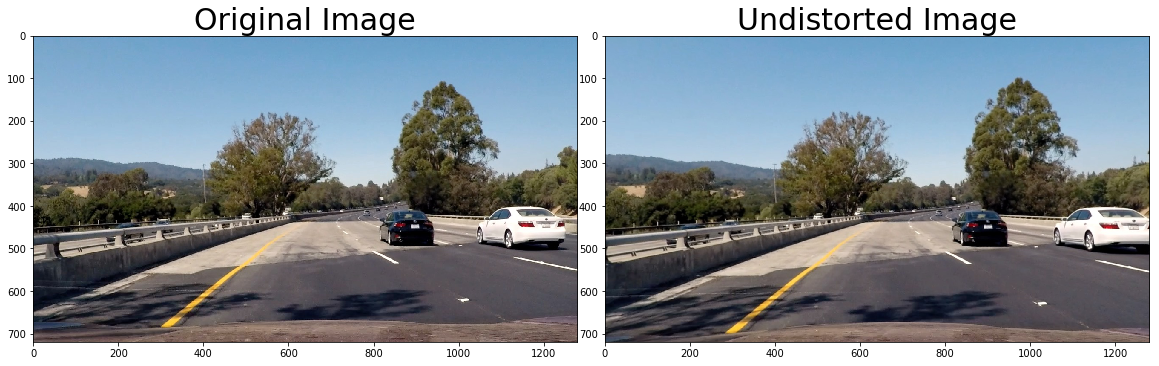

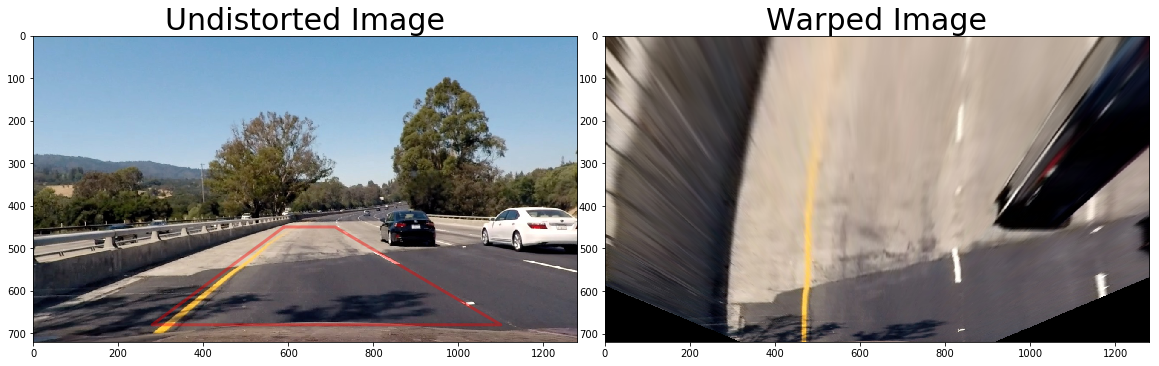

In [5]:
#prospective transform output of the pipeline 
#create an instance from the lane detection pipeline class 
pipeline = LaneDetection(dist,mtx)

#read one of the test images 
img = mpimg.imread('./test_images/test4.jpg')

pipeline.ProcessImage(img)

#visualize how the pipeline undistorted one of the test images 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(pipeline.img_undst)
ax2.set_title('Undistorted Image', fontsize=30)

# Set up plot
# Visualize warp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)

ax1.imshow(pipeline.img_undst)

h,w = pipeline.img_undst.shape[:2]
x = [pipeline.ProsSrc[0][0],pipeline.ProsSrc[2][0],pipeline.ProsSrc[3][0],pipeline.ProsSrc[1][0],pipeline.ProsSrc[0][0]]
y = [pipeline.ProsSrc[0][1],pipeline.ProsSrc[2][1],pipeline.ProsSrc[3][1],pipeline.ProsSrc[1][1],pipeline.ProsSrc[0][1]]
ax1.plot(x, y, color='r', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)


ax2.imshow(pipeline.warped)

ax2.set_title('Warped Image', fontsize=30)


Window Search started
Forward Search Started
Forward Search Started
Forward Search Started
Forward Search Started
Window Search started
Forward Search Started
Forward Search Started


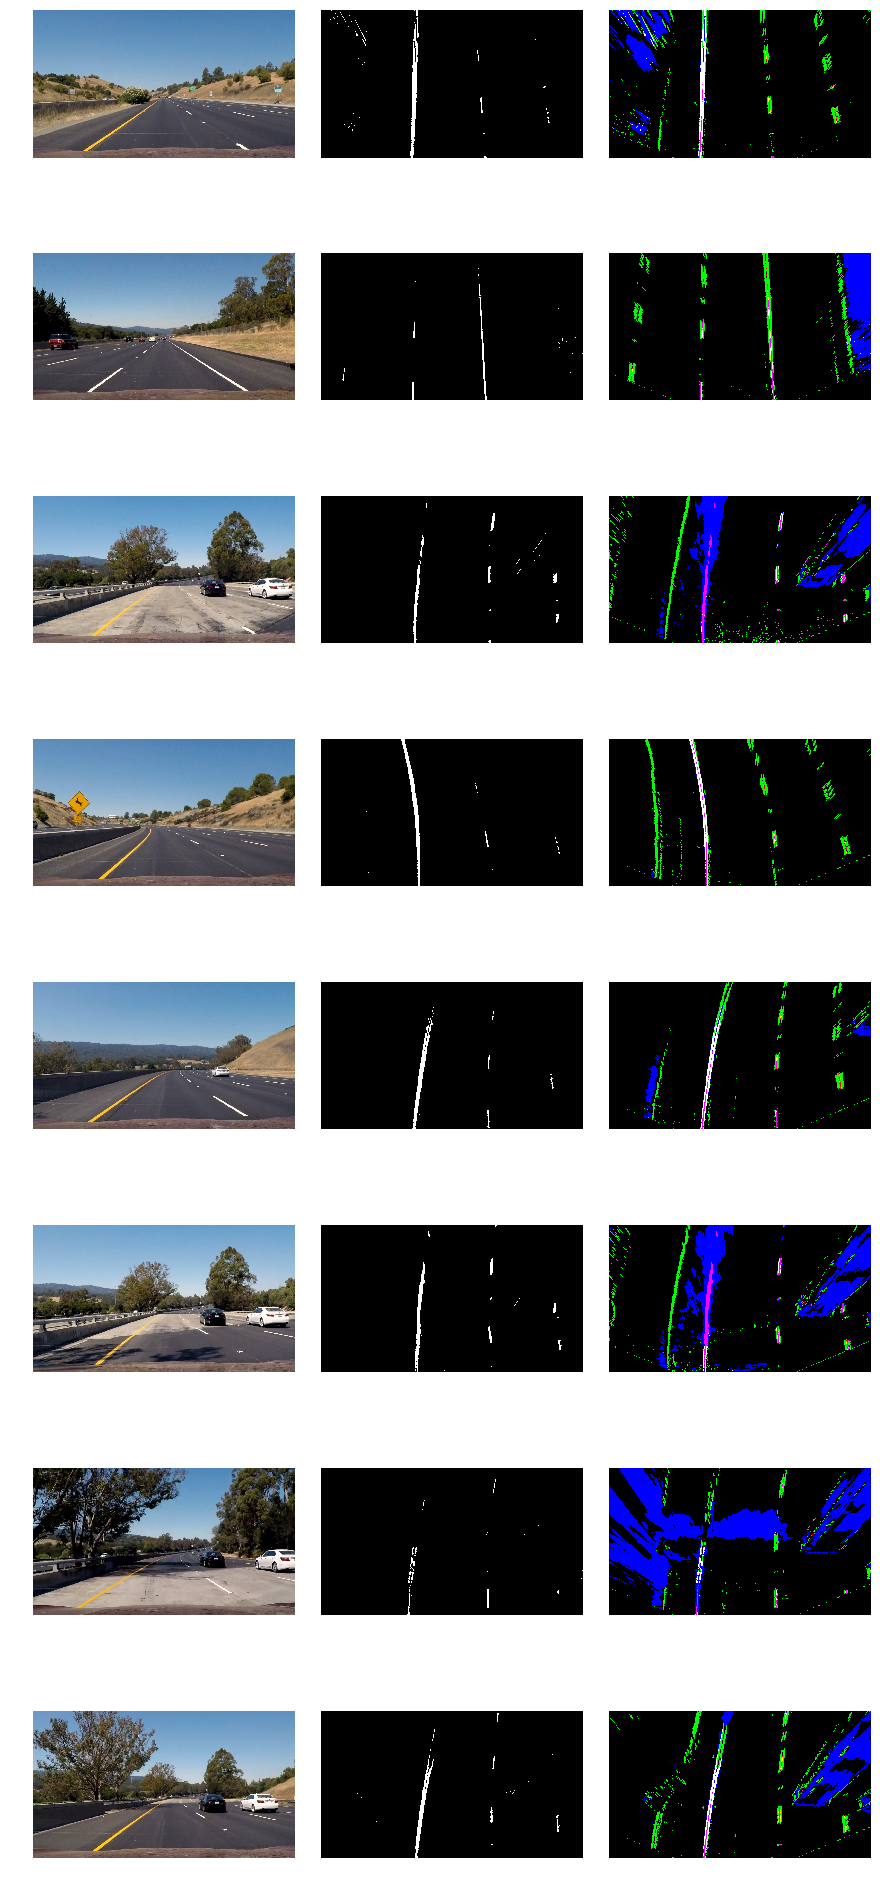

In [6]:
#Pipeline combined binary output results "color threshold and gradient threshold" over the test images 
# Make a list of test images
images = glob.glob('./test_images/*.jpg')
    

#create an instance from the lane detection pipeline class 
pipeline_2 = LaneDetection(dist,mtx)

# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(15, 35))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = mpimg.imread(image)
    pipeline_2.ProcessImage(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(pipeline_2.combined_binary, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].imshow(pipeline_2.color_binary, cmap='gray')
    axs[i].axis('off')
    i += 1

    

Window Search started
Window Search started
Window Search started
Window Search started
Window Search started
Window Search started
Window Search started
Window Search started
Window Search started
Forward Search Started


(-0.5, 1279.5, 719.5, -0.5)

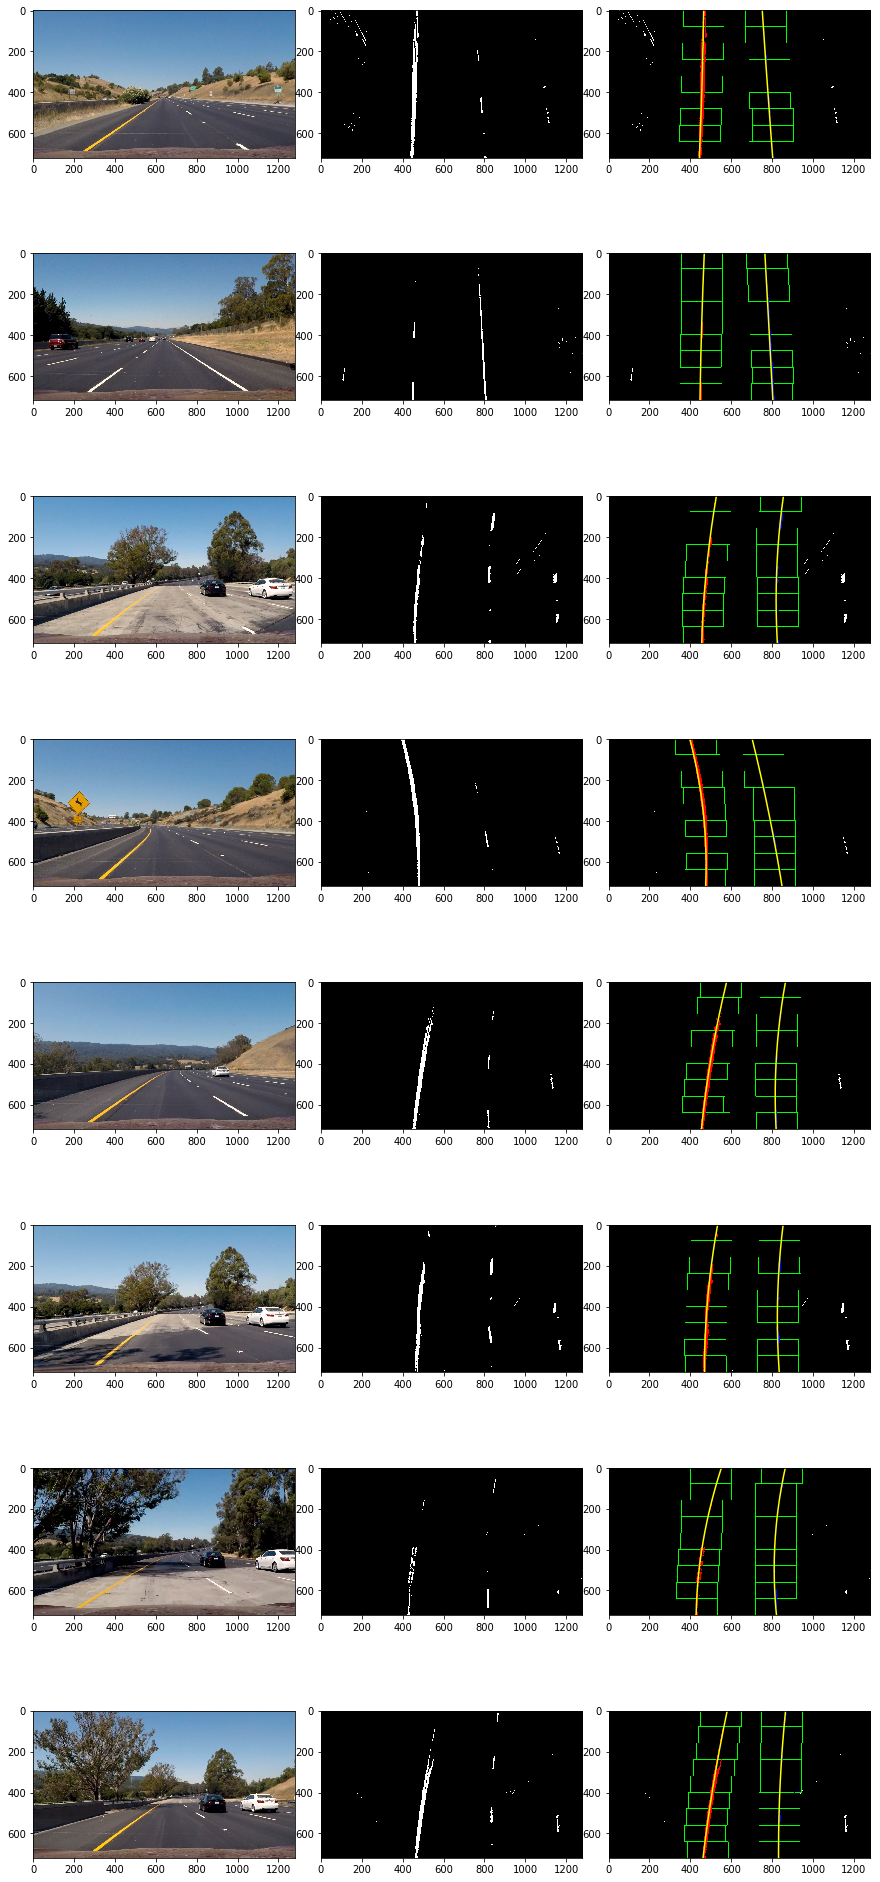

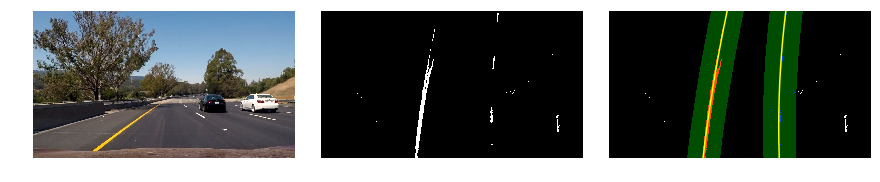

In [7]:
#Pipeline window searching ouput over the test images & an example over the forward search 
# Make a list of test images
images = glob.glob('./test_images/*.jpg')

#read sample image to use it the generation of ploty
img = mpimg.imread('./test_images/test2.jpg')

# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(15, 35))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

#generate the ploty 
ploty = np.linspace(0,img.shape[0]-1, img.shape[0] )

#loop on all test images 
i = 0    
for image in images:
    
    img = mpimg.imread(image)
    
    #create an instance from the lane detection pipeline class 
    pipeline_3 = LaneDetection(dist,mtx)
    
    pipeline_3.ProcessImage(img)
    
    axs[i].imshow(img)
    i += 1
    axs[i].imshow(pipeline_3.combined_binary, cmap='gray')
    i += 1
    axs[i].imshow(pipeline_3.sliding_search_img, cmap='gray')
    
    axs[i].plot(pipeline_3.left_line.recent_xfitted[-1], ploty, color='yellow')
    axs[i].plot(pipeline_3.right_line.recent_xfitted[-1], ploty, color='yellow')
    
    i += 1
    
    #delete object of pipeline to starte again over a new input image
    del pipeline_3
    
#------------------------Visualize the forward search----------------------------------
i = 0
fig, axs = plt.subplots(1,3, figsize=(15, 35))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

#create an instance from the lane detection pipeline class 
pipeline_3 = LaneDetection(dist,mtx)
#call the process function to starte the sliding window search 
pipeline_3.ProcessImage(img)
#call the process function againg to start the forward search for the same image
#set the flag that allow forward search darwing 
pipeline_3.visualize_searching_window = True
pipeline_3.ProcessImage(img)

axs[i].imshow(img)
axs[i].axis('off')
i += 1
axs[i].imshow(pipeline_3.combined_binary, cmap='gray')
axs[i].axis('off')
i += 1
axs[i].imshow(pipeline_3.window_search_img, cmap='gray')
#draw the fitting lines for both lane sides 
axs[i].plot(pipeline_3.left_line.recent_xfitted[-1], ploty, color='yellow')
axs[i].plot(pipeline_3.right_line.recent_xfitted[-1], ploty, color='yellow')
axs[i].axis('off')


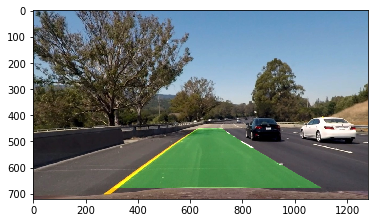

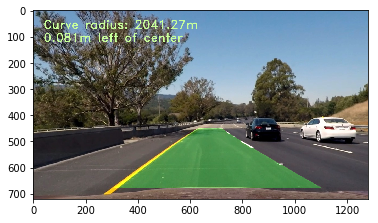

In [8]:
#------------------------Visualize the drawing lane and the calculated curvature -----

plt.figure()
plt.imshow(pipeline_3.lane_img)

plt.figure()
plt.imshow(pipeline_3.final_img)

In [9]:
#-------------project video output ---------- 
pipeline_4 = LaneDetection(dist,mtx)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('./project_video.mp4')
processed_video = video_input1.fl_image(pipeline_4.ProcessImage)
%time processed_video.write_videofile(video_output1, audio=False)

OSError: MoviePy error: the file ./project_video.mp4 could not be found !
Please check that you entered the correct path.